# Predicting Likes and Retweets

In this notebook:
* Settings for ridge regression
* Select features to use
* Preprocessing
* Train ridge regression models
* Plot coefficients of resulting models
* Table with coefficients
* Table with correlations

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Open Tweets

In [2]:
path_clinton = '../Data/tweets_clinton_20151109_20161109_readability_extrafeatures.json'

with open(path_clinton, encoding="utf8") as f:
    tweets_clinton = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_clinton['created_at'] = tweets_clinton['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

In [3]:
tweets_clinton = tweets_clinton.dropna()
tweets_clinton.shape

(6002, 63)

In [4]:
path_trump = '../Data/tweets_trump_20151109_20161109_readability_extrafeatures.json'

with open(path_trump, encoding="utf8") as f:
    tweets_trump = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_trump['created_at'] = tweets_trump['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

In [5]:
tweets_trump = tweets_trump.dropna()
tweets_trump.shape

(4968, 63)

## Groups of Features

In [6]:
readability_features = [
    'readability grades Kincaid', 'readability grades ARI',
    'readability grades Coleman-Liau', 'readability grades FleschReadingEase',
    'readability grades GunningFogIndex', 'readability grades LIX',
    'readability grades SMOGIndex', 'readability grades RIX',
    'readability grades DaleChallIndex'
]

sentence_info_features = [
    'sentence info characters_per_word', 'sentence info syll_per_word',
    'sentence info words_per_sentence', 'sentence info sentences_per_paragraph',
    'sentence info type_token_ratio', 'sentence info characters',
    'sentence info syllables', 'sentence info words', 'sentence info wordtypes',
    'sentence info sentences', 'sentence info paragraphs', 'sentence info long_words',
    'sentence info complex_words', 'sentence info complex_words_dc'
]

word_usage_features = [
    'word usage tobeverb', 'word usage auxverb', 'word usage conjunction',
    'word usage pronoun', 'word usage preposition', 'word usage nominalization'
]

sentence_beginnings_features = [
    'sentence beginnings pronoun', 'sentence beginnings interrogative',
    'sentence beginnings article', 'sentence beginnings subordination',
    'sentence beginnings conjunction', 'sentence beginnings preposition'
]

In [7]:
source = ['source']

topic_features = ['topic_hashtag']

presence_features = ['presence url', 'presence mention', 'presence hashtag']

time_features = [
    'days before election', 'day monday', 'day tuesday', 'day wednesday',
    'day thursday', 'day friday', 'day saturday', 'day sunday', 'hour of the day'
]

mention_features = [
    'mention trump', 'mention clinton', 'mention dem candidate',
    'mention rep candidate', 'mention obama'
]

### Settings

In [8]:
# Scaler to use
# MinMaxScaler transforms data to a scale between 0 and 1
# See: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()

In [9]:
# Values of alpha to use in ridge regression with cross validation
alphas = [0.001, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2, 2.5, 3, 4, 5, 5.25, 5.5, 6, 6.25, 6.5, 7, 7.5, 8, 10.0, 15, 20, 30, 40]

In [10]:
# Whether to log transform y
log = True

# Random state for splitting into training and testing setss
random = 79

In [11]:
# Seaborn styles
sns.set_style("white")
sns.set_context("talk")

### RidgeCV function

In [12]:
def use_ridgeCV(y, tweets, columns, encode_columns, random_state, alphas, log):

    X = tweets[columns][tweets['is_retweet'] == False]
    y = tweets[y][tweets['is_retweet'] == False]
    
    # Dummy encode
    if len(encode_columns) > 0:
        X = pd.get_dummies(X, prefix = encode_columns, prefix_sep = ' ', columns = encode_columns)

    # Save column names
    column_names = X.columns

    # Scale all values in all columns
    X = scaler.fit_transform(X)

    # Log transform y
    if log:
        y = y.apply(lambda x: np.log(x + 1))

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    # Train and test
    ridge = RidgeCV(alphas = alphas)
    ridge.fit(X_train, y_train)
    train_score = ridge.score(X_train, y_train)
    test_score = ridge.score(X_test, y_test)
    coeff_used = np.sum(ridge.coef_ != 0)
    
    print('Training score: ' + str(train_score))
    print('Test score: ' + str(test_score))
    print('Number of features used: ' + str(coeff_used))

    if ridge.alpha_:
        alpha = ridge.alpha_
        print('Alpha: ' + str(alpha))

    coefs = zip(column_names, ridge.coef_)
    coefs = list(coefs)
    coefs_df = pd.DataFrame(coefs, columns = ['label', 'coef'])
    coefs_df = coefs_df.set_index('label')
    
    return ridge, column_names, train_score, test_score, coefs_df, alpha

### Plot

In [13]:
def neaten_labels(coefs_df):
    labels = []

    for label in coefs_df:
        label = label.replace('readability grades FleschReadingEase', 'flesch reading-ease')
        label = label.replace('negative', 'neg.')
        label = label.title() # Start every word with capital character
        label = label.replace(' Us ', ' US ')
        label = label.replace('_Hashtag', '') # Remove underscore and 'hashtag'
        labels.append(label)

    return labels

In [14]:
nicer_labels = [
    'Flesch Reading-Ease',
    'Presence Url',
    'Presence Mention',
    'Presence Hashtag',
    'Days Before Election',
    'Mention Trump',
    'Mention Clinton',
    'Mention Dem Candidate',
    'Mention Rep Candidate',
    'Mention Obama',
    'Topic Debates',
    'Topic Event',
    'Topic Foreign Policy',
    'Topic Geographic',
    'Topic Media',
    'Topic Minorities',
    'Topic Miscellaneous',
    'Topic Neg. About Opp.',
    'Topic No Topic',
    'Topic Nomination',
    'Topic Other Policy Issues',
    'Topic Political Party',
    'Topic Slogans',
    'Topic US Government',
    'Topic Voting',
    "Topic Women's Rights"
]

In [15]:
def plot_ridgeCV_coefs(y, coefs_trump, coefs_clinton, alpha_trump, alpha_clinton, test_score_trump, test_score_clinton, log,):

    fig, ax = plt.subplots(figsize=(12, 6.5))
    
    if log:
        # Exponentiate the coefficients
        coefs_trump["coef"] = np.exp(coefs_trump["coef"]) - 1
        coefs_clinton["coef"] = np.exp(coefs_clinton["coef"]) - 1

    # Plot coefficients
    plt.plot(
        coefs_trump,
        alpha = 0.5,
        linestyle = 'none',
        marker = 'o',
        markersize = 8,
        color = 'orangered',
        label = r'Trump; $\alpha$ = ' + str(round(alpha_trump, 1)) + '; Test Score = ' + str(round(test_score_trump, 2))
    )
    plt.plot(
        coefs_clinton,
        alpha = 0.5,
        linestyle = 'none',
        marker = '^',
        markersize = 8,
        color = 'royalblue',
        label = r'Clinton; $\alpha$ = ' + str(round(alpha_clinton, 1)) + '; Test Score = ' + str(round(test_score_clinton, 2))
    )
    
    # Careful: whether this range is appropriate depends on the data and on other settings
    plt.ylim([-1, 7.5])
    
    # Title based on y variable
    title_font = {'fontweight': 'bold', 'fontsize': 20}
    if y == 'favorite_count':
        plt.title('Predicting Likes with RidgeCV', fontdict = title_font)
    elif y == 'retweet_count':
        plt.title('Predicting Retweets with RidgeCV', fontdict = title_font)
    else:
        plt.title('')
    
    # Make x tick labels nicer, set y axis label, move legend
    plt.xticks(list(range(0, 26)), nicer_labels, rotation = 90)
    plt.xticks(rotation = 90)
    plt.ylabel('Coefficient Magnitude')
    plt.legend(loc = 'upper right')
    plt.grid()
    
    # Save file with name based on y variable
    if y == 'favorite_count':
        plt.savefig('../Plots/coefplot_ridge_fav_trumpclinton.pdf', format = 'pdf', bbox_inches = "tight")
    elif y == 'retweet_count':
        plt.savefig('../Plots/coefplot_ridge_ret_trumpclinton.pdf', format = 'pdf', bbox_inches = "tight")
    else:
        print('Was not able to save plot.')
    

## Features

In [16]:
columns_all = ['readability grades FleschReadingEase'] + topic_features + presence_features + ['days before election'] + mention_features

In [17]:
# Columns to dummy encode
encode_columns = topic_features

## Likes: FRE, topic, presence, 'days before election', mention

In [18]:
ridge_clinton, column_names_clinton, train_score_clinton, test_score_clinton, coefs_clinton_df_likes, alpha_clinton = use_ridgeCV('favorite_count', tweets_clinton, columns_all, encode_columns, random, alphas, log)

Training score: 0.37300255107542724
Test score: 0.3574147145258709
Number of features used: 24
Alpha: 5.5


In [19]:
ridge_trump, column_names_trump, train_score_trump, test_score_trump, coefs_trump_df_likes, alpha_trump = use_ridgeCV('favorite_count', tweets_trump, columns_all, encode_columns, random, alphas, log)

Training score: 0.576642095197323
Test score: 0.6712810660001156
Number of features used: 25
Alpha: 5.0


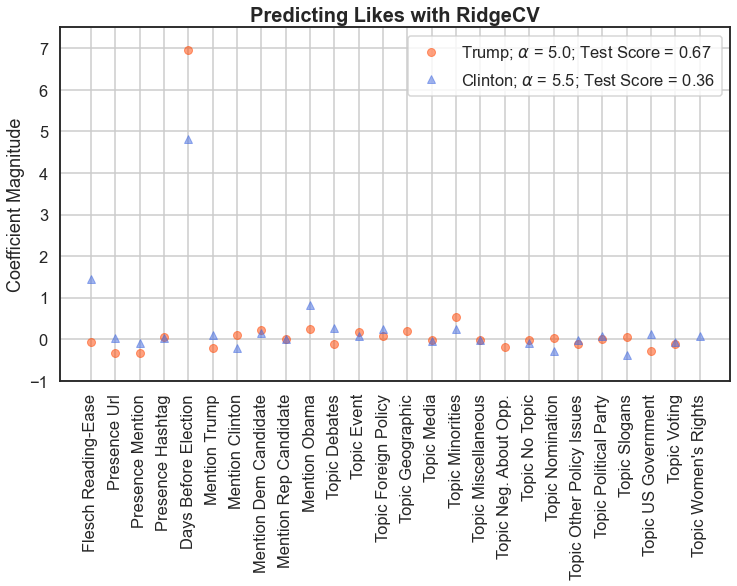

In [20]:
plot_ridgeCV_coefs('favorite_count', coefs_trump_df_likes, coefs_clinton_df_likes, alpha_trump, alpha_clinton, test_score_trump, test_score_clinton, log)

## Retweets: FRE, topic, presence, 'days before election', mention

In [21]:
ridge_clinton, column_names_clinton, train_score_clinton, test_score_clinton, coefs_clinton_df_rets, alpha_clinton = use_ridgeCV('retweet_count', tweets_clinton, columns_all, encode_columns, random, alphas, log)

Training score: 0.3367929379979603
Test score: 0.3214528652098174
Number of features used: 24
Alpha: 6.5


In [22]:
ridge_trump, column_names_trump, train_score_trump, test_score_trump, coefs_trump_df_rets, alpha_trump = use_ridgeCV('retweet_count', tweets_trump, columns_all, encode_columns, random, alphas, log)

Training score: 0.5585097650839987
Test score: 0.6242094520809267
Number of features used: 25
Alpha: 6.0


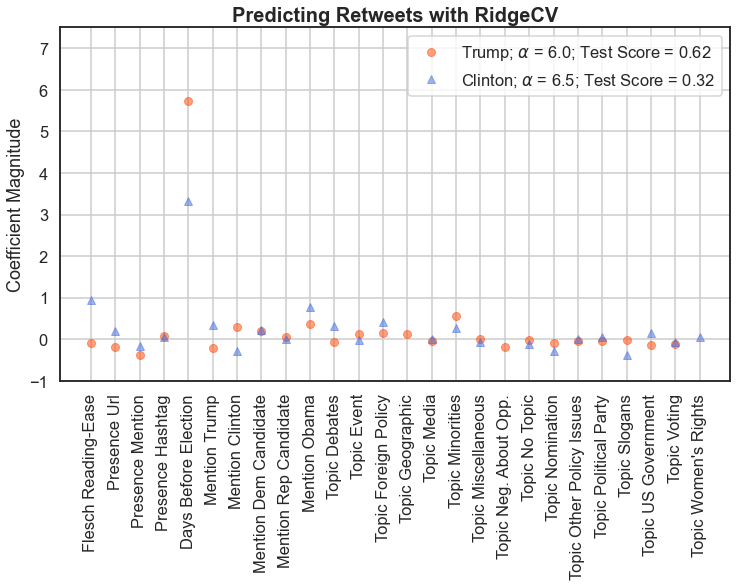

In [23]:
plot_ridgeCV_coefs('retweet_count', coefs_trump_df_rets, coefs_clinton_df_rets, alpha_trump, alpha_clinton, test_score_trump, test_score_clinton, log)

## Table with all coefficients

In [24]:
def coef_table(coefs_trump_df_likes, coefs_clinton_df_likes, coefs_trump_df_rets, coefs_clinton_df_rets):

    # Round coefficients to 3 decimals
    coefs_trump_df_likes['coef'] = np.around(coefs_trump_df_likes['coef'], decimals = 3)
    coefs_clinton_df_likes['coef'] = np.around(coefs_clinton_df_likes['coef'], decimals = 3)
    coefs_trump_df_rets['coef'] = np.around(coefs_trump_df_rets['coef'], decimals = 3)
    coefs_clinton_df_rets['coef'] = np.around(coefs_clinton_df_rets['coef'], decimals = 3)
    
    # Rename columns
    coefs_trump_df_likes = coefs_trump_df_likes.rename(columns={"coef": "Likes Trump"})
    coefs_clinton_df_likes = coefs_clinton_df_likes.rename(columns={"coef": "Likes Clinton"})
    coefs_trump_df_rets = coefs_trump_df_rets.rename(columns={"coef": "Retweets Trump"})
    coefs_clinton_df_rets = coefs_clinton_df_rets.rename(columns={"coef": "Retweets Clinton"})

    # Add lists of coefficients to one dataframe
    coefs_table = pd.concat([coefs_trump_df_likes, coefs_clinton_df_likes, coefs_trump_df_rets, coefs_clinton_df_rets], axis = 1)
    
    coefs_table = coefs_table.fillna('-')
    
    # Change index to 'nice' labels
    coefs_table['Feature'] = nicer_labels
    coefs_table = coefs_table.set_index('Feature')
    
    return coefs_table

In [25]:
coefs_table = coef_table(coefs_trump_df_likes, coefs_clinton_df_likes, coefs_trump_df_rets, coefs_clinton_df_rets)

In [26]:
print(coefs_table.to_latex(bold_rows = True))

\begin{tabular}{lllll}
\toprule
{} & Likes Trump & Likes Clinton & Retweets Trump & Retweets Clinton \\
\textbf{Feature                  } &             &               &                &                  \\
\midrule
\textbf{Flesch Reading-Ease      } &      -0.073 &         1.456 &         -0.092 &            0.941 \\
\textbf{Presence Url             } &      -0.335 &         0.042 &         -0.176 &            0.187 \\
\textbf{Presence Mention         } &      -0.339 &        -0.102 &         -0.376 &           -0.169 \\
\textbf{Presence Hashtag         } &       0.060 &         0.032 &          0.081 &            0.052 \\
\textbf{Days Before Election     } &       6.966 &         4.817 &          5.725 &            3.320 \\
\textbf{Mention Trump            } &      -0.215 &         0.101 &         -0.210 &            0.340 \\
\textbf{Mention Clinton          } &       0.111 &        -0.202 &          0.294 &           -0.272 \\
\textbf{Mention Dem Candidate    } &       0.221 &     

### Correlations table

In [27]:
def corr_table(tweets_trump, tweets_clinton, columns, encode_columns, outcome_var):
    # Number of decimals for rounding the r coefficients and p-values
    round_r = 2
    round_p = 3
    
    # Remove categorical features, while preserving order
    columns = [item for item in columns if item not in encode_columns]
    
    # Remove tweets that were retweeted by candidates
    tweets_trump = tweets_trump[tweets_trump['is_retweet'] == False]
    tweets_clinton = tweets_clinton[tweets_clinton['is_retweet'] == False]
    
    # Log transform outcome variable
    if log:
        tweets_trump[outcome_var] = tweets_trump[outcome_var].apply(lambda x: np.log(x + 1))
        tweets_clinton[outcome_var] = tweets_clinton[outcome_var].apply(lambda x: np.log(x + 1))
    
    # Calculate correlations between feature and outcome variable for trump and clinton
    # And add the r and p-value to a dataframe
    table = pd.DataFrame()
    for feature in columns:
        corr_tr = stats.pearsonr(tweets_trump[feature], tweets_trump[outcome_var])
        corr_cl = stats.pearsonr(tweets_clinton[feature], tweets_clinton[outcome_var])

        row = pd.Series([round(corr_tr[0], round_r), round(corr_cl[1], round_p),
                         round(corr_cl[0], round_r), round(corr_cl[1], round_p),])
        row_df = pd.DataFrame([row], index = neaten_labels([feature]))
        table = pd.concat([table, row_df])
        
    print(table.to_latex(bold_rows = True))

In [28]:
corr_table(tweets_trump, tweets_clinton, columns_all, encode_columns, 'favorite_count')

\begin{tabular}{lrrrr}
\toprule
{} &     0 &      1 &     2 &      3 \\
\midrule
\textbf{Flesch Reading-Ease  } & -0.02 &  0.000 &  0.15 &  0.000 \\
\textbf{Presence Url         } & -0.00 &  0.071 &  0.02 &  0.071 \\
\textbf{Presence Mention     } & -0.40 &  0.000 & -0.08 &  0.000 \\
\textbf{Presence Hashtag     } & -0.00 &  0.372 & -0.01 &  0.372 \\
\textbf{Days Before Election } &  0.70 &  0.000 &  0.57 &  0.000 \\
\textbf{Mention Trump        } & -0.30 &  0.000 &  0.20 &  0.000 \\
\textbf{Mention Clinton      } &  0.26 &  0.000 & -0.13 &  0.000 \\
\textbf{Mention Dem Candidate} &  0.11 &  0.710 &  0.01 &  0.710 \\
\textbf{Mention Rep Candidate} & -0.08 &  0.906 & -0.00 &  0.906 \\
\textbf{Mention Obama        } &  0.09 &  0.000 &  0.08 &  0.000 \\
\bottomrule
\end{tabular}



<ipython-input-27-6fa834d0f7f6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_trump[outcome_var] = tweets_trump[outcome_var].apply(lambda x: np.log(x + 1))
<ipython-input-27-6fa834d0f7f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_clinton[outcome_var] = tweets_clinton[outcome_var].apply(lambda x: np.log(x + 1))


In [29]:
corr_table(tweets_trump, tweets_clinton, columns_all, encode_columns, 'retweet_count')

\begin{tabular}{lrrrr}
\toprule
{} &     0 &      1 &     2 &      3 \\
\midrule
\textbf{Flesch Reading-Ease  } & -0.00 &  0.000 &  0.13 &  0.000 \\
\textbf{Presence Url         } &  0.09 &  0.000 &  0.07 &  0.000 \\
\textbf{Presence Mention     } & -0.44 &  0.000 & -0.10 &  0.000 \\
\textbf{Presence Hashtag     } &  0.03 &  0.564 &  0.01 &  0.564 \\
\textbf{Days Before Election } &  0.69 &  0.000 &  0.50 &  0.000 \\
\textbf{Mention Trump        } & -0.31 &  0.000 &  0.27 &  0.000 \\
\textbf{Mention Clinton      } &  0.30 &  0.000 & -0.17 &  0.000 \\
\textbf{Mention Dem Candidate} &  0.10 &  0.623 &  0.01 &  0.623 \\
\textbf{Mention Rep Candidate} & -0.07 &  0.981 & -0.00 &  0.981 \\
\textbf{Mention Obama        } &  0.10 &  0.000 &  0.07 &  0.000 \\
\bottomrule
\end{tabular}



<ipython-input-27-6fa834d0f7f6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_trump[outcome_var] = tweets_trump[outcome_var].apply(lambda x: np.log(x + 1))
<ipython-input-27-6fa834d0f7f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_clinton[outcome_var] = tweets_clinton[outcome_var].apply(lambda x: np.log(x + 1))
